# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
import radvel.plotting
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

rcParams['font.size'] = 18

Populating the interactive namespace from numpy and matplotlib


In [2]:
def bin_same_night(rv):
    rv['jd_date'] = rv['time'].apply(lambda x: np.int(np.floor(x)))
    rv_mean = rv.groupby('jd_date',as_index=False).mean()
    rv_n = rv.groupby('jd_date',as_index=False).size()
    print rv['tel'].iloc[0], len(rv_n)
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922_fixed.txt')
data = pd.read_csv(path, usecols=(0,1,2,3), delim_whitespace=True)

rv_hires_rk = data.query("tel == 'k'")
rv_hires_rj = data.query("tel == 'j'")
rv_apf = data.query("tel == 'a'")

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = linspace(t_start,t_stop,10000)

j 122
k 49
a 69


/Users/bfulton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [3]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = 1201.1 + 0.4
    params['tc1'] = 2456778 + 1
    params['secosw1'] = 0.01 
    params['sesinw1'] = 0.01
    params['logk1'] = 1
    params['per2'] = 75.765 + 0.1
    params['tc2'] = 2456277.6
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1
    params['dvdt'] = 0
    params['curv'] = 0
    mod = radvel.RVModel(params, time_base=time_base)
    return mod

def plot_results(like,color,label):
    fig = gcf()
    axL = fig.get_axes()
    jit = like.params[like.jit_param]
    yerr = np.sqrt(like.yerr**2 + jit**2)
    bjd0 = 2450000

    sca(axL[0])
    errorbar(
        like.x-bjd0, like.model(like.x)+like.residuals(), 
        yerr=yerr, fmt='o',color=color,label=label
        )
    plot(ti-bjd0, like.model(ti), 'g-')
    fig.set_tight_layout(True)
    sca(axL[1])
    errorbar(
        like.x-bjd0, like.residuals(), 
        yerr=yerr, fmt='o', color=color
        )


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = 1.0
like_hires_rj.params['jit_hires_rj'] = np.log(1)

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = 1.0
like_hires_rk.params['jit_hires_rk'] = np.log(1)

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = 1.0
like_apf.params['jit_apf'] = np.log(1)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = log(2.6)
like.params['jit_hires_rj'] = log(2.6)
like.params['jit_apf'] = log(2.6)

# Do not vary dvdt or jitter (Fulton 2015)
like.vary['dvdt'] = False
like.vary['curv'] = False
like.vary['jit_hires_rk'] = False
like.vary['jit_hires_rj'] = False
like.vary['jit_apf'] = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )


print "Initial loglikelihood = %f" % post0.logprob()
print "Final loglikelihood = %f" % post.logprob()
print post

Initial loglikelihood = -1418.041736
Final loglikelihood = -764.776474
parameter                     value      vary
per1                        1199.28       True
tc1                         6779.48       True
secosw1                   -0.238608       True
sesinw1                    0.252247       True
logk1                        1.9721       True
per2                        75.7715       True
tc2                         6277.94       True
secosw2                   0.0069338       True
sesinw2                    0.437631       True
logk2                      0.766698       True
dvdt                              0      False
curv                              0      False
jit_hires_rj               0.955511      False
gamma_hires_rj             0.224739       True
jit_hires_rk               0.955511      False
gamma_hires_rk             0.154315       True
jit_apf                    0.955511      False
gamma_apf                   1.02202       True

Priors
------
e1 constrained to be <

## Make a nice plot

/Users/bfulton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


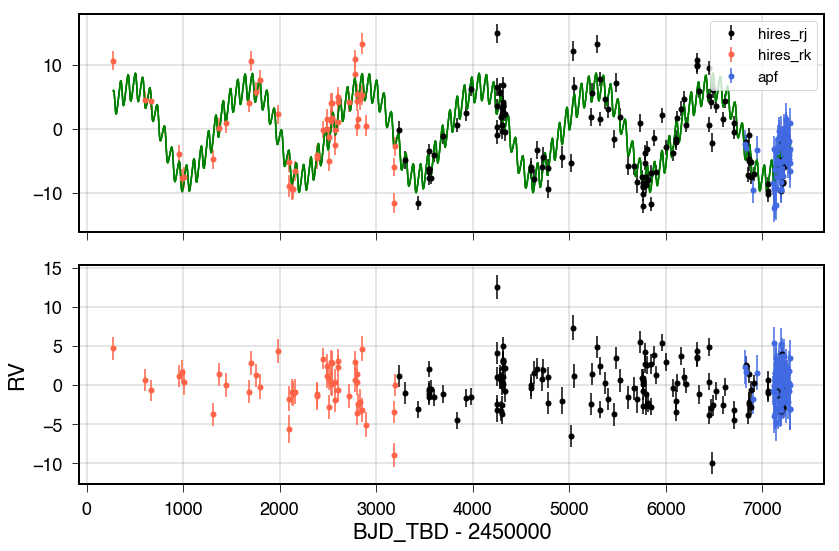

In [6]:
plt.close('all')
fig,axL = subplots(nrows=2,figsize=(12,8),sharex=True)
plot_results(like.like_list[0],'black','hires_rj') # plot best fit model
plot_results(like.like_list[1],'Tomato','hires_rk') # plot best fit model
plot_results(like.like_list[2],'RoyalBlue','apf') # plot best fit model
axL[0].legend()
bjd0 = 2450000
xlabel('BJD_TBD - %i' % bjd0)
ylabel('RV')
[ax.grid() for ax in axL]
draw()

# Perform MCMC posterior exploration

In [9]:
df = radvel.mcmc(post, nrun=1000)


Discarding burn-in now that the chains are marginally well-mixed


Chains are well-mixed after 220000 steps! MCMC completed in 37.3 seconds




In [10]:
df_cps = post.params.basis.to_cps(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_cps[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.5,0.84
per1,1.196825e+03,1.199108e+03,1.201087e+03
tc1,2.456772e+06,2.456779e+06,2.456785e+06
e1,9.899829e-02,1.198710e-01,1.389486e-01
k1,7.009459e+00,7.171979e+00,7.324559e+00
per2,7.574000e+01,7.577392e+01,7.580550e+01
tc2,2.456277e+06,2.456278e+06,2.456279e+06
e2,1.117524e-01,1.839736e-01,2.424486e-01
k2,1.972968e+00,2.131338e+00,2.274432e+00
gamma_hires_rj,8.522392e-02,2.262796e-01,3.528834e-01
gamma_hires_rk,-9.149897e-02,1.574682e-01,3.829824e-01


Compare with parameters from fulton et al. (2016)
---------

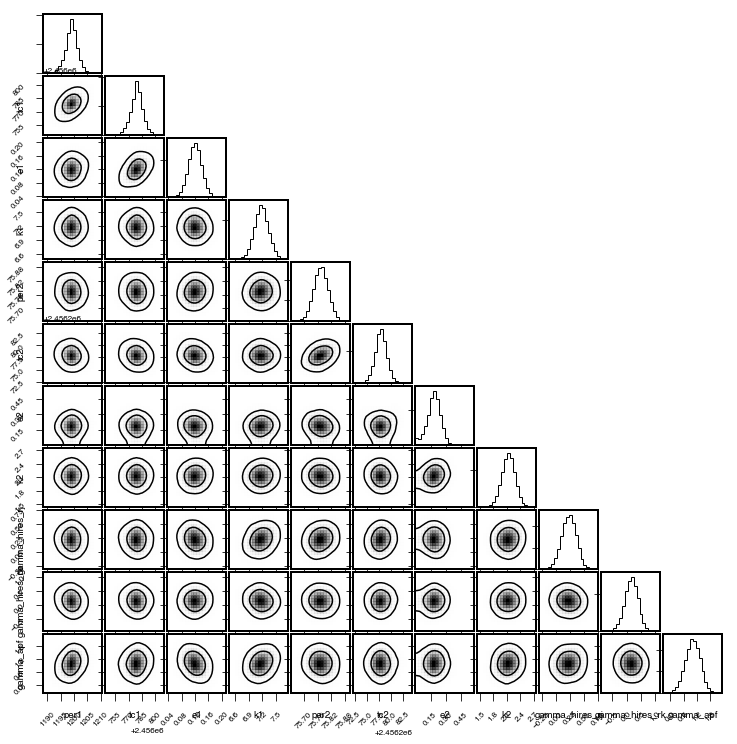

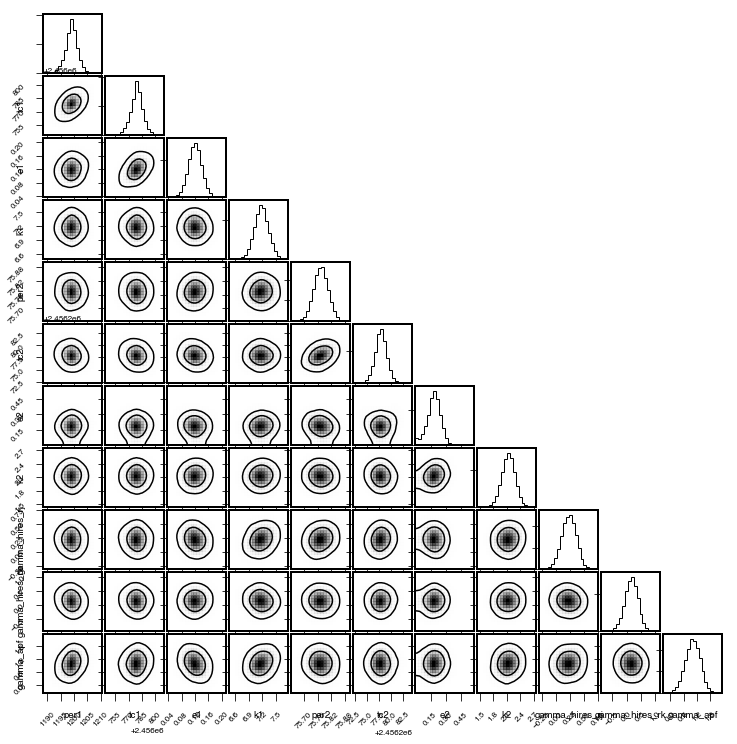

In [11]:
,close all
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
rc('font',size=8)
dims = len(labels)
fig,axL = subplots(nrows=dims,ncols=dims,figsize=(10,10))
corner_kw = dict(
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    )
corner.corner(df_cps[labels],fig=fig,**corner_kw)

(<matplotlib.figure.Figure at 0x107b556d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10a0a9690>])

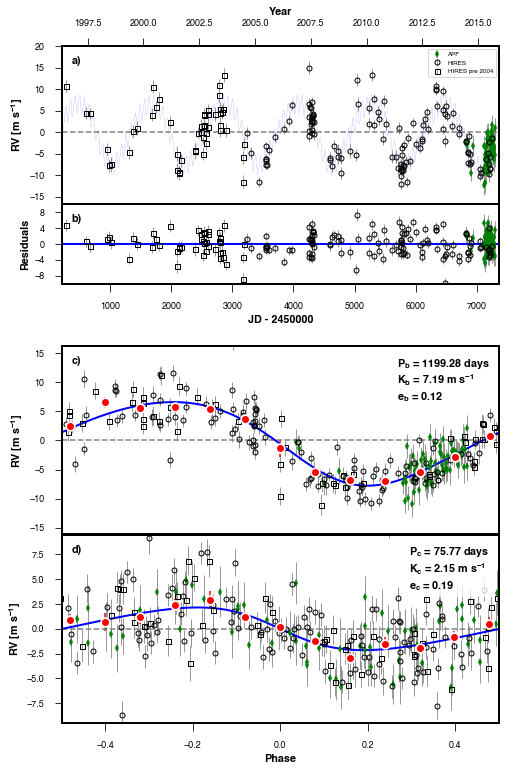

In [12]:
reload(radvel.plotting)
radvel.plotting.rv_multipanel_plot(post)